In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary

# **1. чтение данных**

In [ ]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

In [ ]:
Batch_Size = 256

In [ ]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# **2. просмотр данных (формат, размер, форма)**

In [ ]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [ ]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


# **3. просмотр изображения**

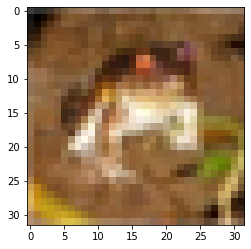

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

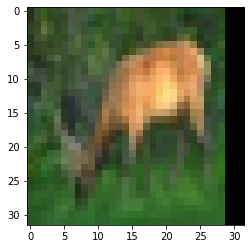

In [ ]:
imshow(im[0])

In [ ]:
im[0].shape

torch.Size([3, 32, 32])

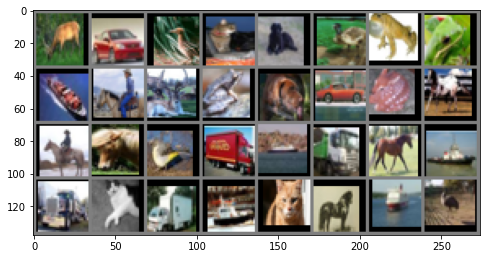

In [ ]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

# **4. определение сети (AlexNet)**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# 定义神经网络  
class AlexNet(nn.Module):  # 训练 ALexNet
    '''
    5层卷积，3层全连接
    ''' 
    def __init__(self):
        super(AlexNet, self).__init__()
        # 五个卷积层 输入 32 * 32 * 3
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1),   # (32-3+2)/1+1 = 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (32-2)/2+1 = 16
        )
        self.conv2 = nn.Sequential(  # 输入 16 * 16 * 6
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1),  # (16-3+2)/1+1 = 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (16-2)/2+1 = 8
        )
        self.conv3 = nn.Sequential(  # 输入 8 * 8 * 16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # (8-3+2)/1+1 = 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (8-2)/2+1 = 4
        )
        self.conv4 = nn.Sequential(  # 输入 4 * 4 * 64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (4-3+2)/1+1 = 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (4-2)/2+1 = 2
        )
        self.conv5 = nn.Sequential(  # 输入 2 * 2 * 128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),# (2-3+2)/1+1 = 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (2-2)/2+1 = 1
        )                            # 最后一层卷积层，输出 1 * 1 * 128
        # 全连接层
        self.dense = nn.Sequential(
            nn.Linear(128, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size()[0],-1)
        x = self.dense(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    

net = AlexNet().to(device)

In [ ]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
              ReLU-2            [-1, 6, 32, 32]               0
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]             880
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          18,496
             ReLU-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Conv2d-13            [-1, 128, 2, 2]          73,856
             ReLU-14            [-1, 12

In [ ]:
print(net)

AlexNet(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [ ]:
test_x = torch.randn(1,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([1, 10])


In [ ]:
net =AlexNet().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

# **5. определение функций потерь и оптимизаторов**

In [ ]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5 ,patience = 5,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
import time
epoch = 20

# **6. Обучение**

In [ ]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/AlexNet.pth'

In [ ]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np

def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std


def get_acc(outputs, label):
    total = outputs.shape[0]
    probs, pred_y = outputs.data.max(dim=1) # 得到概率
    correct = (pred_y == label).sum().data
    return correct / total


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss

def train(net, trainloader, testloader, epoches, optimizer , criterion, scheduler , path = './model.pth', writer = None ,verbose = False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_acc = 0
    train_acc_list, test_acc_list = [],[]
    train_loss_list, test_loss_list = [],[]
    lr_list  = []
    for i in range(epoches):
        start = time.time()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            # 释放内存
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            # formard
            outputs = net(im)
            loss = criterion(outputs,label)
            # backward
            loss.backward()
            # 更新参数
            optimizer.step()

            train_loss += loss.data
            # probs, pred_y = outputs.data.max(dim=1) # 得到概率
            # # 正确的个数
            # train_acc += (pred_y==label).sum().item()
            # # 总数
            # total += label.size(0)
            train_acc += get_acc(outputs,label)
            # 打印下载进度
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc * 100 / len(trainloader)
        if verbose:
            train_acc_list.append(train_acc.item())
            train_loss_list.append(train_loss.item())
    #     print('train_loss:{:.6f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')  
        # 记录学习率
        lr = optimizer.param_groups[0]['lr']
        if verbose:
            lr_list.append(lr)
        # 更新学习率
        scheduler.step(train_loss)
        if testloader is not None:
            net.eval()
            with torch.no_grad():
                for step,data in enumerate(testloader,start=0):
                    im,label = data
                    im = im.to(device)
                    label = label.to(device)
                    # 释放内存
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
                    outputs = net(im)
                    loss = criterion(outputs,label)
                    test_loss += loss.data
                    # probs, pred_y = outputs.data.max(dim=1) # 得到概率
                    # test_acc += (pred_y==label).sum().item()
                    # total += label.size(0)
                    test_acc += get_acc(outputs,label)
                    rate = (step + 1) / len(testloader)
                    a = "*" * int(rate * 50)
                    b = "." * (50 - int(rate * 50))
                    print('\r test  {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
            test_loss = test_loss / len(testloader)
            test_acc = test_acc * 100 / len(testloader)
            if verbose:
                test_loss_list.append(test_loss.item())
                test_acc_list.append(test_acc.item())
            end = time.time()
            print(
                '\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoches, train_loss, train_acc, test_loss, test_acc,lr), end='')
        else:
            end = time.time()
            print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(i+1,epoches,train_loss,train_acc,lr),end = '')
        time_ = int(end - start)
        h = time_ / 3600
        m = time_ % 3600 /60
        s = time_ % 60
        time_str = "\tTime %02d:%02d" % ( m, s)
        # ====================== 使用 tensorboard ==================
        if writer is not None:
            writer.add_scalars('Loss', {'train': train_loss,
                                    'valid': test_loss}, i+1)
            writer.add_scalars('Acc', {'train': train_acc ,
                                   'valid': test_acc}, i+1)
            writer.add_scalars('Learning Rate',lr,i+1)
        # =========================================================
        # 打印所用时间
        print(time_str)
        # 如果取得更好的准确率，就保存模型
        if test_acc > best_acc:
            torch.save(net,path)
            best_acc = test_acc
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['test_acc'] = test_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['test_loss'] = test_loss_list
    Lr = lr_list
    return Acc, Loss, Lr

def train2(net, trainloader, testloader, epoches, optimizer , criterion, scheduler , path = './model.pth', verbose = False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_acc = 0
    train_acc_list, test_acc_list = [],[]
    train_loss_list, test_loss_list = [],[]
    lr_list  = []
    for i in range(epoches):
        start = time.time()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            # 释放内存
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            # formard
            outputs = net(im)
            loss = criterion(outputs,label)
            # backward
            loss.backward()
            # 更新参数
            optimizer.step()

            train_loss += loss.data
            # probs, pred_y = outputs.data.max(dim=1) # 得到概率
            # # 正确的个数
            # train_acc += (pred_y==label).sum().item()
            # # 总数
            # total += label.size(0)
            train_acc += get_acc(outputs,label)
            # 打印下载进度
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc * 100 / len(trainloader)
        if verbose:
            train_acc_list.append(train_acc.item())
            train_loss_list.append(train_loss.item())
    #     print('train_loss:{:.6f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')  
        # 记录学习率
        lr = optimizer.param_groups[0]['lr']
        if verbose:
            lr_list.append(lr)
        # 更新学习率
        scheduler.step()
        if testloader is not None:
            net.eval()
            with torch.no_grad():
                for step,data in enumerate(testloader,start=0):
                    im,label = data
                    im = im.to(device)
                    label = label.to(device)
                    # 释放内存
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
                    outputs = net(im)
                    loss = criterion(outputs,label)
                    test_loss += loss.data
                    # probs, pred_y = outputs.data.max(dim=1) # 得到概率
                    # test_acc += (pred_y==label).sum().item()
                    # total += label.size(0)
                    test_acc += get_acc(outputs,label)
                    rate = (step + 1) / len(testloader)
                    a = "*" * int(rate * 50)
                    b = "." * (50 - int(rate * 50))
                    print('\r test  {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
            test_loss = test_loss / len(testloader)
            test_acc = test_acc * 100 / len(testloader)
            if verbose:
                test_loss_list.append(test_loss.item())
                test_acc_list.append(test_acc.item())
            end = time.time()
            print(
                '\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoches, train_loss, train_acc, test_loss, test_acc,lr), end='')
        else:
            end = time.time()
            print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(i+1,epoches,train_loss,train_acc,lr),end = '')
        time_ = int(end - start)
        h = time_ / 3600
        m = time_ % 3600 /60
        s = time_ % 60
        time_str = "\tTime %02d:%02d" % ( m, s)
        # 答应所用时间
        print(time_str)
        # 如果取得更好的准确率，就保存模型
        if test_acc > best_acc:
            torch.save(net,path)
            best_acc = test_acc
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['test_acc'] = test_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['test_loss'] = test_loss_list
    Lr = lr_list
    return Acc, Loss, Lr

def plot_history(epoches, Acc, Loss, lr):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, lr)
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

In [ ]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Epoch [  1/ 20]  Train Loss:2.257973  Train Acc:12.51% Test Loss:2.071463  Test Acc:21.11%  Learning Rate:0.100000	Time 00:33
Epoch [  2/ 20]  Train Loss:1.956442  Train Acc:25.77% Test Loss:1.867858  Test Acc:29.38%  Learning Rate:0.100000	Time 00:32
Epoch [  3/ 20]  Train Loss:1.721805  Train Acc:34.67% Test Loss:1.755987  Test Acc:36.36%  Learning Rate:0.100000	Time 00:32
Epoch [  4/ 20]  Train Loss:1.567613  Train Acc:41.56% Test Loss:1.472750  Test Acc:43.75%  Learning Rate:0.100000	Time 00:32
Epoch [  5/ 20]  Train Loss:1.431637  Train Acc:47.94% Test Loss:1.450019  Test Acc:48.76%  Learning Rate:0.100000	Time 00:32
Epoch [  6/ 20]  Train Loss:1.340318  Train Acc:51.64% Test Loss:1.295367  Test Acc:53.63%  Learning Rate:0.100000	Time 00:32
Epoch [  7/ 20]  Train Loss:1.269947  Train Acc:54.64% Test Loss:1.294452  Test Acc:53.64%  Learning Rate:0.100000	Time 00:32
Epoch [  8/ 20]  Train Loss:1.222677  Train Acc:56.87% Test Loss:1.277995  Test Acc:55.23%  Learning Rate:0.100000	Tim

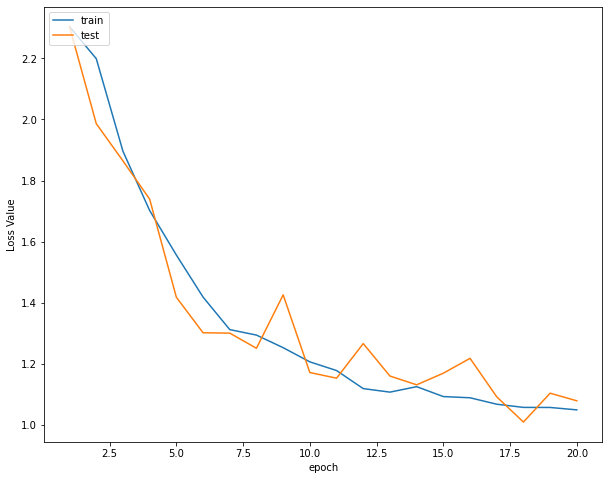

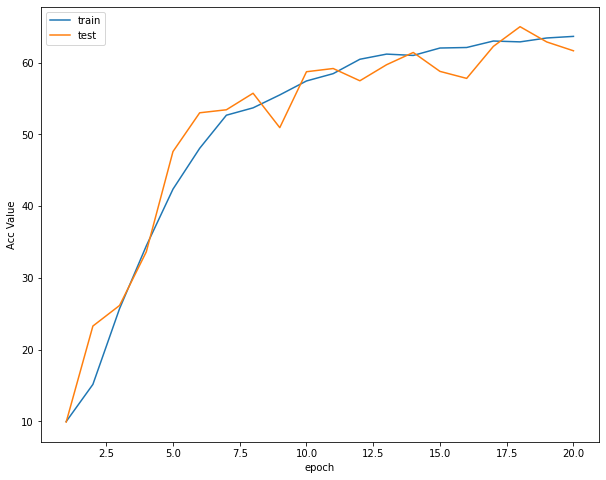

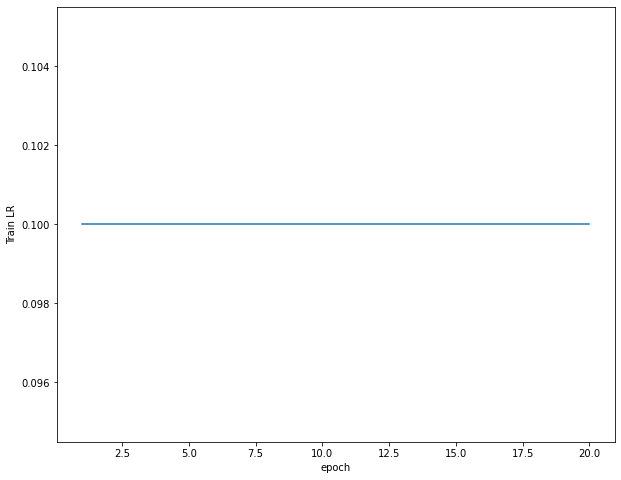

In [ ]:
plot_history(epoch ,Acc, Loss, Lr)

# **7. Тестирование**

In [ ]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 62.69 %


In [ ]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 51.30 %
Accuracy of automobile : 84.50 %
Accuracy of  bird : 51.70 %
Accuracy of   cat : 66.10 %
Accuracy of  deer : 62.40 %
Accuracy of   dog : 34.10 %
Accuracy of  frog : 48.20 %
Accuracy of horse : 71.70 %
Accuracy of  ship : 77.60 %
Accuracy of truck : 79.40 %


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)


correct = torch.sum(val_preds == labels.data).item()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

# **8. сохранение моделей**

In [ ]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')
# torch.save(net, './model/ResNet34.pth')

# **9. прогнозирование**

In [30]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AlexNet()

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("/content/airplane.jpg").convert('RGB') # 读取图像

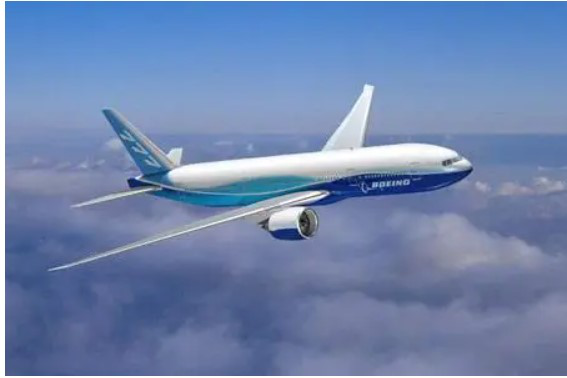

In [31]:
img

In [33]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[9.6714e-01, 6.2335e-04, 1.4427e-03, 1.1184e-04, 7.0102e-04, 2.4761e-05,
         5.9523e-06, 1.5220e-04, 2.8264e-02, 1.5309e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 0
tensor([7.1718], device='cuda:0')
分类 plane


<Response [200]>


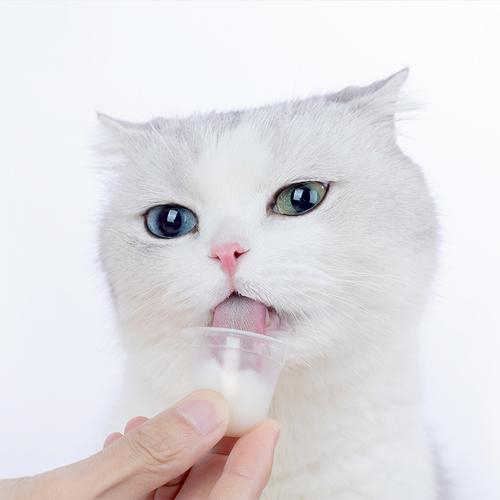

In [34]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [36]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[0.2471, 0.0148, 0.0846, 0.1601, 0.0692, 0.1554, 0.0072, 0.0755, 0.1596,
         0.0265]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
类别 0
tensor([1.3437], device='cuda:0')
分类 plane
